### Mechanical Power Vital File Processing 
* Sangwon Baek / SNUH / Vital Lab 
* Jan 9th 2024 

In [1]:
import vitaldb

import pandas as pd
from pandas import Timestamp, Timedelta
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from itertools import chain
from tqdm import tqdm
import datetime

import re
import os
import glob
import random
from collections import defaultdict
import gc  

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Display first 50 rows of dataframe
pd.set_option('display.max_rows', 50)

import matplotlib as mpl 

#Set Global Matplotlib parameters for font 
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12

In [2]:
def collect_file_data(years, check_preprocessed=False):
    # Initialize a dictionary to hold filenames and file paths for each year
    file_names, file_paths = {}, {}

    # Initialize an empty list to store all file paths across years
    all_filenames, all_file_paths = [], []

    # Print Original if check_preprocessed = False else print Preprocessed
    print(f"Collecting {'Original' if not check_preprocessed else 'Preprocessed'} data...")
    
    # Iterate over each year, get filenames, and count .vital files
    for year in years:
        path = f'../Data/Preprocessed/{year}/' if check_preprocessed else f'../Data/Original/{year}/'
        try:
            filenames = os.listdir(path)
        except FileNotFoundError:
            print(f"Directory not found: {path}")
            continue

        # Store filenames and file paths for the current year
        file_names[year] = filenames
        year_file_paths = [os.path.join(path, filename) for filename in filenames]
        file_paths[year] = year_file_paths

        # Extend all_file_paths list with file paths from the current year
        all_file_paths.extend(year_file_paths)
        all_filenames.extend(filenames)

        # Count and print the number of .vital files
        vital_file_count = len([f for f in filenames if f.endswith('.vital')])
        print(f'Got a total of {vital_file_count} vital files for MP research in 20{year}')

    # Return total count of all file_paths
    print(f"Total number of {'Original' if not check_preprocessed else 'Preprocessed'} files: {len(all_file_paths)}")
    
    return all_filenames, all_file_paths

def get_track_names(device_combinations, additional_track_names):
    # Include all possible track names from the device_combinations
    track_names = set()  # Use a set to avoid duplicates
    for combo in device_combinations.values():
        for tracks in combo.values():
            track_names.update(tracks)

    track_names.update(additional_track_names)
    return list(track_names)

def data_preprocessor(vf, all_track_names):

    vf_df = vf.to_pandas(interval=1, return_datetime=True, track_names=all_track_names)

    # Conversion factor from mBar to cmH2O (1 mBar = 1.0197162129779 cmH2O)
    conversion_factor = 1.0197162129779
    # List of track names that require conversion
    tracks_to_convert = [
        "Solar8000/VENT_PIP", "Solar 8000M/VENT_PIP", "Solar8000/VENT_MEAS_PEEP",
        "Solar8000/VENT_TOTAL_PEEP", "Solar 8000M/VENT_TOTAL_PEEP", "Solar8000/VENT_PEEP",
        "Solar 8000M/VENT_PEEP", "Solar8000/VENT_PPLAT", "Solar 8000M/VENT_PPLAT",
        "Primus/PIP_MBAR", "Primus/PEEP_MBAR", "Primus/PPLAT_MBAR",
        "Intellivue/PIP", "Intellivue/PEEP", "Intellivue/PPLAT",
        "Primus/COMPLIANCE" 
    ]
    
    # Apply conversion to all tracks in one go if they exist in the dataframe
    tracks_existing = [track for track in tracks_to_convert if track in vf_df.columns]
    vf_df[tracks_existing] *= conversion_factor

    return vf_df

In [3]:
def missing_rate_finder(df, time_column='Time'):
    # Calculate the missing rate for each column
    missing_rates = df.drop(columns=[time_column], errors='ignore').isnull().mean() * 100
    return missing_rates

def check_combination(df, combination, combo_number):
    # Categories to exclude from the check
    exclude_categories = ['SPO2', 'SBP']

    # Remove excluded categories from the combination before checking
    filtered_combination = {category: tracks for category, tracks in combination.items() if category not in exclude_categories}

    for category, required_tracks in filtered_combination.items():
        # Handle special condition for 'F' in combination 2 and 4 (Datex-Ohmeda specific)
        if (combo_number == 2 or combo_number == 4) and category == 'F':
            # Check if both 'FLOW_O2' and 'FLOW_AIR' must exist and not all values are null
            flow_o2_exists = 'Datex-Ohmeda/FLOW_O2' in df.columns and not df['Datex-Ohmeda/FLOW_O2'].isnull().all()
            flow_air_exists = 'Datex-Ohmeda/FLOW_AIR' in df.columns and not df['Datex-Ohmeda/FLOW_AIR'].isnull().all()
            if not (flow_o2_exists and flow_air_exists):
                print(f"Failed special check for 'F' category in combination {combo_number}")
                return False
        else:
            # General condition for other categories
            if not any(track in df.columns and not df[track].isnull().all() for track in required_tracks):
                print(f"Failed check for category: {category} with tracks: {required_tracks}")
                return False
            
    print("All categories checked successfully.")
    return True

def check_critical_columns_validity(df, critical_columns):
    for col in critical_columns:
        if col not in df.columns or df[col].isnull().all() or (df[col] == 0).all():
            return False
    return True

def missing_column_finder(df, time_column='Time'):
    # Calculate the missing rate for each column
    missing_rates = df.drop(columns=[time_column], errors='ignore').isnull().mean() * 100

    # Exclude datetime columns from the sum check
    non_datetime_columns = df.select_dtypes(exclude=['datetime', 'datetimetz']).columns

    # Additionally consider non-datetime columns with sum of values as zero as missing
    for col in non_datetime_columns:
        # Convert to numeric if possible, coerce errors to NaN
        numeric_col = pd.to_numeric(df[col], errors='coerce')
        if numeric_col.sum() == 0:
            missing_rates[col] = 100
    
    return missing_rates

def crop_df(df, vent_on, vent_off):
    df['Time'] = df['Time'].dt.tz_localize(None)  # Making 'Time' timezone-naive
    vent_on = vent_on.tz_localize(None) if vent_on else None
    vent_off = vent_off.tz_localize(None) if vent_off else None
    
    # Crop the dataframe based on adjusted ventilator on/off time 
    if vent_on is not None and vent_off is not None:
        df = df[(df['Time'] >= vent_on) & (df['Time'] <= vent_off)]
    return df

def check_missing_mp(df):
    column_name = 'Combined_MP'

    # Check if cropped_df is empty after exclusions, or the specific column does not exist
    if len(df) == 0 or column_name not in df.columns:
        return True, 1.0  

    total = len(df)
    missing_count = df[column_name].isnull().sum()
    missing_proportion = missing_count / total if total > 0 else 0

    return missing_count > 0, missing_proportion

def check_tracks_presence(df, device_combinations, category, vent_on, vent_off, extended_time_ranges):
    
    start_end_pairs = [(dt_range[0], dt_range[-1]) for dt_range in extended_time_ranges]
    
    # Get the combination number for the specified category
    specified_tracks = list(set(track for combo in device_combinations.values() for track in combo.get(category, [])))

    # Crop the dataframe based on ventilator on/off time
    cropped_df = crop_df(df, vent_on, vent_off) 

    # Exclude times specified in start_end_pairs from cropped_df
    for start, end in start_end_pairs:
        # Ensure start and end are proper Timestamps for comparison
        start, end = pd.to_datetime(start), pd.to_datetime(end)
        # Exclude rows within the start and end range
        cropped_df = cropped_df[~((cropped_df['Time'] >= start) & (cropped_df['Time'] <= end))]

    # Check if the specified tracks exist in the dataframe
    missing_rates = missing_column_finder(cropped_df)

    # Check if any track in the specified category exists and is not missing
    results = not any(missing_rates.get(track, 100) < 100 for track in specified_tracks)
    return results

In [4]:
def get_necessary_vent_rows(df):
    # Check for Primus and Datex-Ohmeda columns in the DataFrame
    has_primus = any(col.startswith("Primus/") for col in df.columns)
    has_datex_ohmeda = any(col.startswith("Datex-Ohmeda/") for col in df.columns)

    if has_primus:
        # Primary and secondary columns for Primus
        primary_col = "Primus/SET_TV_L" if "Primus/SET_TV_L" in df.columns else None
        secondary_col = "Primus/SET_INTER_PEEP" if "Primus/SET_INTER_PEEP" in df.columns else None

        # Filter based on the available columns
        if primary_col and secondary_col:
            df_filtered = df.dropna(subset=[primary_col, secondary_col], how='all').reset_index(drop=True)
        elif primary_col:
            df_filtered = df.dropna(subset=[primary_col]).reset_index(drop=True)
        else:
            df_filtered = df.dropna(subset=[secondary_col]).reset_index(drop=True) if secondary_col else pd.DataFrame()

    elif has_datex_ohmeda:
        # Columns of interest for Datex-Ohmeda
        if "Datex-Ohmeda/SET_MODE" in df.columns:
            df_filtered = df.dropna(subset=["Datex-Ohmeda/SET_MODE"], how='all').reset_index(drop=True)
            # Transform the Datex-Ohmeda/SET_MODE column to contain only 'VOLUME' or null
            df_filtered["Datex-Ohmeda/SET_MODE"] = df_filtered["Datex-Ohmeda/SET_MODE"].apply(lambda x: x if x.lower() == "volume" else None)
        else:
            df_filtered = pd.DataFrame()

    else:
        df_filtered = pd.DataFrame()  # Return an empty DataFrame if no device type is found

    return df_filtered

def get_ventilator_on_off_time(df, switch):
    # Initialize variables 
    consecutive_count = 0
    index = None

    # Check for the device type based on columns
    if "Primus/SET_TV_L" in df.columns or "Primus/SET_INTER_PEEP" in df.columns:
        device_type = 'Primus'
        interval = 15
        consecutive_threshold = 6
        column_to_check = "Primus/SET_TV_L" if "Primus/SET_TV_L" in df.columns else "Primus/SET_INTER_PEEP"
    elif "Datex-Ohmeda/SET_MODE" in df.columns:
        device_type = 'Datex-Ohmeda'
        interval = 15
        consecutive_threshold = 6
        column_to_check = "Datex-Ohmeda/SET_MODE"
    else:
        print("No device type found. Ventilator on/off time cannot be determined.")
        return None
    
    # Filter out unnecessary rows and columns 
    df_filtered = get_necessary_vent_rows(df)

    # Choose loop direction based on switch
    if switch == "on":
        loop_range = range(len(df_filtered))
    elif switch == "off":
        loop_range = range(len(df_filtered) - 1, -1, -1)
    else:
        raise ValueError("Invalid switch value. Use 'on' or 'off'.")
    
    for i in loop_range:
        if pd.notnull(df_filtered[column_to_check].iloc[i]):
            if index is None:
                index = i
                consecutive_count = 1
                continue

            time_diff = abs(df_filtered['Time'].iloc[index] - df_filtered['Time'].iloc[i]).total_seconds()
            expected_time = interval * consecutive_threshold + interval * 2

            if time_diff >= expected_time:
                index = i
                consecutive_count = 1
            elif time_diff < expected_time:
                consecutive_count += 1

            if consecutive_count >= consecutive_threshold:
                return df_filtered['Time'].iloc[index]

        else:
            index = None
            consecutive_count = 0
    # Return None if ventilator has non-null counts  
    print("No ventilator on/off time is found")
    return None

def get_op_start_end_times(df_opdata, file_path):
    # Extract the filename from the file path
    extracted_file_name = re.sub(r'^\.\./Data/Original/\d{2}/', '', file_path)

    # Find the corresponding row in df_opdata
    op_data_row = df_opdata[df_opdata['fileid'] == extracted_file_name]

    if not op_data_row.empty:
        seoul_timezone = pytz.timezone('Asia/Seoul')

        # Safely convert opstart and opend to datetime objects
        opstart = pd.to_datetime(op_data_row['opstart'].iloc[0], errors='coerce')
        opend = pd.to_datetime(op_data_row['opend'].iloc[0], errors='coerce')

        # Check if either conversion resulted in NaT
        if pd.isnull(opstart) or pd.isnull(opend):
            print(f"Fail: opstart and opend not converted to datetime for file: {extracted_file_name}")
            return None, None

        # Convert opstart and opend to UTC timezone
        opstart = opstart.replace(tzinfo=seoul_timezone).astimezone(pytz.utc)
        opend = opend.replace(tzinfo=seoul_timezone).astimezone(pytz.utc)

        return opstart, opend

    # Return None if the data is not available or conversion to datetime failed
    return None, None

In [5]:
def check_null_vent_intervals(df, opstart, opend):

    # Check for the column to check based on device type
    if "Primus/SET_TV_L" in df.columns or "Primus/SET_INTER_PEEP" in df.columns:
        column_to_check = "Primus/SET_TV_L" if "Primus/SET_TV_L" in df.columns else "Primus/SET_INTER_PEEP"
    elif "Datex-Ohmeda/SET_MODE" in df.columns:
        column_to_check = "Datex-Ohmeda/SET_MODE"
    else:
        print("No device type found for ventilator. Not a valid file.")
        return True, None

    # Convert opstart and opend to tz-naive datetimes if they are tz-aware
    opstart = pd.to_datetime(opstart).tz_localize(None)
    opend = pd.to_datetime(opend).tz_localize(None)
    
    # Convert df['Time'] to datetime, remove milliseconds and timezone
    df['Time'] = pd.to_datetime(df['Time']).dt.tz_localize(None)
    df['Time'] = df['Time'].dt.floor('S')  # Remove milliseconds

    # Generate time range from opstart to opend
    op_time_range = pd.date_range(start=opstart, end=opend, freq='S')  # Assuming data is recorded every second
    op_df = pd.DataFrame(op_time_range, columns=['Time'])

    # Merge op_df and df based on 'Time' column
    df_merged = pd.merge(op_df, df, on='Time', how='left')

    # Find where the consecutive null values in the column_to_check exceed 10 minutes
    df_merged['null_group'] = (df_merged[column_to_check].notnull().shift() != df_merged[column_to_check].notnull()).cumsum()
    df_merged['null_duration'] = df_merged.groupby('null_group')['Time'].transform(lambda x: x.max() - x.min())

    # Identify null groups with duration over 25 seconds
    null_groups_over_threshold = df_merged[df_merged['null_duration'] > pd.Timedelta(seconds=25)]['null_group'].unique()

    # Empty list for appending extended_time_range
    extended_time_ranges = []

    # Set all values in column_to_check to null for each null group over the threshold in the original df
    for group in null_groups_over_threshold:
        group_times = df_merged[df_merged['null_group'] == group]['Time']
        if not group_times.empty:
            # Extend the group time range by ±1 second
            extended_start = group_times.iloc[0] - pd.Timedelta(seconds=1)
            extended_end = group_times.iloc[-1] + pd.Timedelta(seconds=1)
            # Create an extended time range
            extended_time_range = pd.date_range(start=extended_start, end=extended_end, freq='S')

            # Append the extended time range to the list
            extended_time_ranges.append(extended_time_range)
            # print(f"Time range added to extended_time_ranges: {extended_start} to {extended_end}")
            
    # Print the maximum null_duration only 
    print(f"Maximum null duration: {df_merged['null_duration'].max()}")

    # Print the time range for maximum null duration null group. 
    print(f"Time range for maximum null duration: {df_merged.loc[df_merged['null_duration'].idxmax(), 'Time']} to {df_merged.loc[df_merged['null_duration'].idxmax(), 'Time'] + df_merged.loc[df_merged['null_duration'].idxmax(), 'null_duration']}")

    # If there is any null duration that exceeds 10 minutes, return True
    if any(df_merged.loc[df_merged[column_to_check].isnull(), 'null_duration'] > pd.Timedelta(minutes=10)):
        print("Fail: Detected a 10-minute null interval in ventilators between operation start and end.")
        return True, None 

    return False, extended_time_ranges  # No significant null interval detected

def check_ventoff_periods(df):
    vent_to_check = None
    if "Primus/SET_TV_L" in df.columns or "Primus/SET_INTER_PEEP" in df.columns:
        vent_to_check = "Primus/SET_TV_L" if "Primus/SET_TV_L" in df.columns else "Primus/SET_INTER_PEEP"
    elif "Datex-Ohmeda/SET_MODE" in df.columns:
        vent_to_check = "Datex-Ohmeda/SET_MODE"
    else:
        print("No device type found for ventilator. Not a valid file.")
        return None
    return vent_to_check

def add_events(vf, file_path, df_opdata, df):
    ventilator_null_interval_detected = False
    error_key = False 
    # Get opstart and opend 
    opstart_temp, opend_temp = get_op_start_end_times(df_opdata, file_path)
    
    # Ensure opstart_temp and opend_temp are not NaT before proceeding
    if pd.isnull(opstart_temp) or pd.isnull(opend_temp):
        error_key = True
        return None, None, error_key
    
    # Convert opstart and opend to Unix timestamps
    opstart_ts = opstart_temp.timestamp()
    opend_ts = opend_temp.timestamp()

    # Assuming opstart_ts and opend_ts are Unix timestamps
    seoul_timezone = pytz.timezone('Asia/Seoul')
    opstart = datetime.datetime.fromtimestamp(opstart_ts, tz=seoul_timezone)
    opend = datetime.datetime.fromtimestamp(opend_ts, tz=seoul_timezone)
    print(f"Op Start: {opstart}, Op End: {opend}")

    # Determine the ventilator on and off times
    ventilator_on_ts = get_ventilator_on_off_time(df, "on")
    ventilator_off_ts = get_ventilator_on_off_time(df, "off")
    print(f"Ventilator on: {ventilator_on_ts}, Ventilator off: {ventilator_off_ts}")
    
    # Check ventilator null intervals within opstart and opend (True if detected)
    ventilator_null_interval_detected, extended_time_ranges = check_null_vent_intervals(df, opstart, opend)

    # Initialize event records list with Op Start and Op End
    event_recs = [
        {'val': 'Op Start', 'dt': opstart_ts}, 
        {'val': 'Op End', 'dt': opend_ts}
    ]

    # Add ventilator on event if available
    if ventilator_on_ts is not None:
        event_recs.append({'val': 'Ventilator On', 'dt': ventilator_on_ts.timestamp()})

    # Add ventilator off event if available
    if ventilator_off_ts is not None:
        event_recs.append({'val': 'Ventilator Off', 'dt': ventilator_off_ts.timestamp()})

    vf.add_track('EVENT', event_recs, unit='text')

    return ventilator_null_interval_detected, extended_time_ranges, error_key

In [6]:
def calculate_null_stretches(values):
    """Return a mask indicating positions eligible for filling based on 10+ consecutive nulls in 'values'."""
    is_null = np.isnan(values)
    eligibility_mask = np.zeros_like(values, dtype=bool)

    # Rolling window to check for 10 consecutive nulls
    for i in range(len(values)):
        if i < 9:  # Not enough preceding values to have 10 consecutive nulls
            continue
        if np.all(is_null[max(0, i-9):i+1]):  # Check if all values in this window are null
            eligibility_mask[max(0, i-9):i+1] = True  # Mark this stretch as eligible for filling

    return eligibility_mask

def mp_parameter_selection(df_window, combo_number, device_combinations, columns_to_select):
    # Initialize track names dictionary for storage and copy df_window to avoid SettingWithCopyWarning
    used_track_names = {}
    df_processed = df_window.copy()

    # Add ventilator to check column to the columns_to_select list 
    vent_to_check = check_ventoff_periods(df_window)
    if vent_to_check is not None:
        df_processed['Ventilator'] = df_processed[vent_to_check]
        used_track_names['Ventilator'] = vent_to_check 

    # Special handling for "F track 
    if combo_number in [2, 4]:
        if 'Datex-Ohmeda/FLOW_O2' in df_processed.columns and 'Datex-Ohmeda/FLOW_AIR' in df_processed.columns:
            df_processed['F'] = df_processed['Datex-Ohmeda/FLOW_O2'] + df_processed['Datex-Ohmeda/FLOW_AIR']
            used_track_names['F'] = ['Datex-Ohmeda/FLOW_O2', 'Datex-Ohmeda/FLOW_AIR']
    elif combo_number in [1, 3] and 'Primus/SET_FRESH_FLOW' in df_processed.columns:
        df_processed['F'] = df_processed['Primus/SET_FRESH_FLOW'] / 1000
        used_track_names['F'] = 'Primus/SET_FRESH_FLOW'
            
    # Special handling for CO2 track 
    if combo_number in [2,4] and 'Datex-Ohmeda/ETCO2' in df_processed.columns:
        df_processed['CO2'] = df_processed['Datex-Ohmeda/ETCO2'] * 7.65
        used_track_names['CO2'] = 'Datex-Ohmeda/ETCO2'
    elif combo_number in [1,3] and 'Primus/ETCO2' in df_processed.columns:
        df_processed['CO2'] = df_processed['Primus/ETCO2'] 
        used_track_names['CO2'] = 'Primus/ETCO2'

    for category, options in device_combinations[combo_number].items():
        if category in ['F', 'CO2']:  # Skip already handled categories
            continue

        # Initialize a NumPy array filled with np.nan for the category
        category_values = np.full(df_processed.shape[0], np.nan)
        used_track_names[category] = []
            
        for option in options:
            if option in df_processed.columns:
                # Convert the DataFrame column to a NumPy array for processing, coerce non-numeric to NaN
                option_values = pd.to_numeric(df_processed[option], errors='coerce').to_numpy()
                if category == 'TV':
                    option_values = option_values / 1000 # Unit conversion for TV   

                # Calculate eligibility for filling based on category_values itself
                fill_eligibility_mask = calculate_null_stretches(category_values)
                
                # Now fill category_values where eligible and where option_values are not NaN
                category_values = np.where(fill_eligibility_mask & ~np.isnan(option_values), option_values, category_values)

                # Track the used track name if not already in the list
                if option not in used_track_names[category]:
                    used_track_names[category].append(option)
        
        # After processing all options for the category insert the category_values into the DataFrame
        df_processed[category] = category_values
                   
    # Take only columns that are needed for MP calculation
    final_columns = ['Time', 'Ventilator'] + columns_to_select
    df_processed = df_processed[final_columns]
    
    return df_processed, used_track_names

def impute_window_data(df_window, columns_to_impute):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df_imputed = df_window.copy()

    # Define conditions for each column
    conditions = {
        'MV': lambda x: x if (x >= 0 and x <= 20) else None,
        'RR': lambda x: x if (x >= 0 and x <= 100) else None,
        'TV': lambda x: x if (x >= 0) else None,
        'PEEP': lambda x: x if (x >= 0 and x <= 25) else None, 
        'Peak Pressure': lambda x: x if (x >= 10 and x <= 50) else None,
        'Plateau Pressure': lambda x: x if (x >= 10 and x <= 40) else None,
        'F': lambda x: x if (x > 0 and x <= 20) else None,
        'CO2': lambda x: x if (x >= 0 and x <= 100) else None,
        'Compliance': lambda x: x if (x >= 0 and x <= 100) else None,
        'HR': lambda x: x if (x >= 0 and x <= 200) else None,
        'SBP': lambda x: x if (x >= 0 and x <= 200) else None,
        'SPO2': lambda x: x if (x >= 0 and x <= 100) else None,
    }

    # Apply conditions to each element in the specified columns
    for col in conditions:
        if col in df_imputed.columns:
            df_imputed[col] = df_imputed[col].apply(conditions[col])

    # Apply forward and backward fill with a limit of 10 consecutive nulls
    df_imputed[columns_to_impute] = df_imputed[columns_to_impute].ffill(limit=10)
    
    # Apply backward fill to the first 10 rows for the specified columns
    row_indices = df_imputed.index[:10]  # Get the indices of the first 10 rows
    column_indices = df_imputed.columns.get_indexer(columns_to_impute)  # Get the column indices for columns_to_impute

    # Use .loc[row_indices, column_names] to specifically target the slice for backward fill
    df_imputed.loc[row_indices, df_imputed.columns[column_indices]] = df_imputed.loc[row_indices, df_imputed.columns[column_indices]].bfill()
    
    return df_imputed

def get_median_row_with_conditions(df_window_processed, mp_columns):
    # Initialize a DataFrame to store the median row
    median_row = pd.DataFrame(columns=mp_columns)

    # Special columns to take the last value instead of median
    special_cols = ['CO2', 'Compliance','HR', 'SBP', 'SPO2']

    # Calculate the median for each column or take the last value for special columns
    for col in mp_columns:
        if col in special_cols:
            # Take the last value for 'CO2' and 'Compliance'
            median_row[col] = [df_window_processed[col].iloc[-1]]
        elif df_window_processed[col].isnull().any() or (col != 'PEEP' and df_window_processed[col].sum() == 0):
            # Set to NaN if any null values are present or if sum is zero (excluding 'PEEP')
            median_row[col] = [np.nan]
        else:
            # Calculate median if conditions are not met
            median_row[col] = [df_window_processed[col].median()]

    # Record the last timestamp of the window
    median_row['Time'] = [df_window_processed['Time'].iloc[-1]]

    return median_row

def calculate_simplified_mp(mv, peak_pressure, peep, plateau_pressure):
    conditions = (~np.isnan(mv) & (mv != 0) & ~np.isnan(peak_pressure) & (peak_pressure != 0) & ~np.isnan(peep) & ~np.isnan(plateau_pressure) & (plateau_pressure != 0) &  (peak_pressure > plateau_pressure))
    return np.where(conditions, 0.098 * mv * (peak_pressure - (plateau_pressure - peep) / 2), np.nan)

def calculate_surrogate_mp(mv, peak_pressure, peep, f):
    conditions = (~np.isnan(mv) & (mv != 0) & ~np.isnan(peak_pressure) & (peak_pressure != 0) & ~np.isnan(peep) & ~np.isnan(f) & (f != 0))
    return np.where(conditions, 0.1 * mv * (peak_pressure + peep + f / 6) / 2, np.nan)

def combine_mp_results(median_row, simplified_mp, surrogate_mp):
    # Initialize the fields with default values
    combined_mp = np.nan
    mp_method = '0_None'

    # Set values based on conditions
    if not np.isnan(simplified_mp):
        combined_mp = simplified_mp
        mp_method = '1_Simplified'
    elif not np.isnan(surrogate_mp):
        combined_mp = surrogate_mp
        mp_method = '2_Surrogate'

    # Update the median_row DataFrame
    median_row['Combined_MP'] = combined_mp
    median_row['MP_Method'] = mp_method

    return median_row

def compute_mp_window(df_window_processed, mp_columns):
    # Get the row of median values with conditions
    median_row = get_median_row_with_conditions(df_window_processed, mp_columns)

    # Extract values for MP calculation
    mv_median = median_row['MV'].iloc[0]
    peak_pressure_median = median_row['Peak Pressure'].iloc[0]
    peep_median = median_row['PEEP'].iloc[0]
    plateau_pressure_median = median_row['Plateau Pressure'].iloc[0]
    f_median = median_row['F'].iloc[0]

    # Print MP calculation values
    # print(f"MV: {mv_median}, Peak Pressure: {peak_pressure_median}, PEEP: {peep_median}, Plateau Pressure: {plateau_pressure_median}, F: {f_median}")
    
    # Use helper functions for calculations with median values
    simplified_mp = calculate_simplified_mp(mv_median, peak_pressure_median, peep_median, plateau_pressure_median)
    surrogate_mp = calculate_surrogate_mp(mv_median, peak_pressure_median, peep_median, f_median)

    # Combine the MP results into median_row using the helper function
    median_row = combine_mp_results(median_row, simplified_mp, surrogate_mp)
    median_row['Simplified_MP'] = simplified_mp
    median_row['Surrogate_MP'] = surrogate_mp

    return median_row

def compute_mp_sliding_window(df, start_time, end_time, extended_time_ranges, step_interval, combo_number, device_combinations, columns):
    # Check if end_time is after start_time
    if end_time <= start_time:
        print("Error: end_time is not after start_time")
        return pd.DataFrame(), []

    # Initialize list to store results
    mp_results = []

    # Generate a sequence of timestamps from start_time to end_time with step_interval
    time_range = pd.date_range(start=start_time, end=end_time-pd.Timedelta(minutes=1), freq=pd.Timedelta(seconds=step_interval))

    # Flatten the extended_time_ranges list to easily check for overlaps
    flattened_extended_times = [time for time_range in extended_time_ranges for time in time_range]
    # print(f"extended time ranges: {extended_time_ranges}")
    print(f"flattened times: {flattened_extended_times}")

    # Initialize an empty dictionary to accumulate used track names
    unique_track_names = {}

    # Iterate over the time range
    for window_start in time_range:
        window_end = window_start + pd.Timedelta(seconds=60)  # 1-minute window

        # Check if window is within the dataframe's time range
        if window_end > df['Time'].max():
            break

        # Skip the window if it overlaps with any of the extended time ranges
        if any(window_start <= time <= window_end for time in flattened_extended_times):
            continue

        df_window = df[(df['Time'] >= window_start) & (df['Time'] < window_end)]
        df_window_processed, used_track_names = mp_parameter_selection(df_window, combo_number, device_combinations, columns)
        
        if used_track_names:
            unique_track_names.update(used_track_names)
        
        # Check for null values in the critical columns after processing 
        df_window_imputed = impute_window_data(df_window_processed, columns)

        # Compute MP for the valid window
        mp_row = compute_mp_window(df_window_imputed, columns)

        # Convert mp_row to a dictionary and append to mp_results
        mp_result = mp_row.to_dict(orient='records')[0]  # Convert the single-row DataFrame to a dictionary
        mp_results.append(mp_result)
    
    # Predefined columns for MP results DataFrame
    predefined_columns = ['Time', 'Combined_MP', 'MP_Method', 'Simplified_MP', 'Surrogate_MP',
                          'MV', 'RR', 'TV', 'PEEP', 'Peak Pressure', 'Plateau Pressure', 'F', 'CO2', 'Compliance', 'HR', 'SBP', 'SPO2']

    # Convert the list of dictionaries to a DataFrame
    if not mp_results:  # Check if mp_results list is empty
        mp_results_df = pd.DataFrame(columns=predefined_columns)
    else:
        mp_results_df = pd.DataFrame(mp_results)
    
    # Garbage collection
    del mp_results
    gc.collect()
    
    return mp_results_df, unique_track_names
        

In [7]:
def localize_to_seoul_timezone(mp_df):
    # Ensure the Time column is in datetime format
    mp_df['Time'] = pd.to_datetime(mp_df['Time'])

    # Set the timezone to Seoul
    seoul_timezone = pytz.timezone('Asia/Seoul')
    mp_df['Time'] = mp_df['Time'].dt.tz_localize(seoul_timezone)

    return mp_df

def add_specific_track(vf, df, mp_column, track_name, unit, interval):
    if df is not None:
        mp_recs = [{'val': row[mp_column], 'dt': row['Time'].timestamp()} 
                   for _, row in df.dropna(subset=[mp_column]).iterrows()]
        min_val, max_val = df[mp_column].min(), df[mp_column].max()
        vf.add_track(f'Mechanical Power {interval}/{track_name}', mp_recs, unit=unit, mindisp=min_val, maxdisp=max_val*1.1)

def add_combined_and_method_tracks(vf, df, interval):
    if df is not None:
        combined_mp_recs = [{'val': row['Combined_MP'], 'dt': row['Time'].timestamp()} 
                            for _, row in df.iterrows() if pd.notna(row['Combined_MP'])]
        method_recs = [{'val': row['MP_Method'], 'dt': row['Time'].timestamp()} 
                       for _, row in df.iterrows()]
        min_val, max_val = df['Combined_MP'].min(), df['Combined_MP'].max()
        vf.add_track(f'Mechanical Power {interval}/MP_COMBINED_{interval}', combined_mp_recs, unit='J/min', mindisp=min_val, maxdisp=max_val*1.1)
        vf.add_track(f'Mechanical Power {interval}/MP_METHOD_{interval}', method_recs, unit='text', mindisp=0, maxdisp=0.1)

def add_component_track(vf, df, component, used_track_names, component_units, interval):
    component_recs = [{'val': row[component], 'dt': row['Time'].timestamp()} 
                      for _, row in df.dropna(subset=[component]).iterrows()]
    unit = component_units.get(component, 'U')
    min_val, max_val = df[component].min(), df[component].max()
    
    # Fetch the track name from used_track_names, defaulting to the component name if not found
    track_name_used = used_track_names.get(component, component)

    # Handle formatting of the track name based on whether it's a list, a string, or otherwise
    if isinstance(track_name_used, list):
        # If track_name_used is a list, join the names, replacing '/' with '-'
        track_name_formatted = ', '.join(track_name_used).replace('/', '-')
    elif isinstance(track_name_used, str):
        # If track_name_used is a string, replace '/' with '-'
        track_name_formatted = track_name_used.replace('/', '-')
    else:
        # Fallback to component name if track_name_used is not a list or string
        track_name_formatted = component

    new_track_name = f"{component} ({track_name_formatted})"
    vf.add_track(f"Mechanical Power {interval}/{new_track_name}", component_recs, unit=unit, mindisp=min_val, maxdisp=max_val*1.1)

def add_mp_tracks(vf, mp_df, used_track_names, interval, components):
    # Define the components and their corresponding units
    component_units = {
        'MV': 'L/min',
        'RR': '/min',
        'TV': 'L',
        'PEEP': 'cmH2O',
        'Peak Pressure': 'cmH2O',
        'Plateau Pressure': 'cmH2O',
        'F': 'L/min',
        'CO2': 'mmHg',
        'Compliance': 'mL/cmH2O',    
        'HR': '/min',
        'SBP': 'mmHg',
        'SPO2': '%'
    }

    # Process each type of track and add them to the vital file
    add_specific_track(vf, mp_df, 'Simplified_MP', f'MP_SIMPLIFIED_{interval}', 'J/min', interval)
    add_specific_track(vf, mp_df, 'Surrogate_MP', f'MP_SURROGATE_{interval}', 'J/min', interval)
    add_combined_and_method_tracks(vf, mp_df, interval)
    
    # Add tracks for common components
    for component in components:
        if mp_df is not None and component in mp_df.columns:
            add_component_track(vf, mp_df, component, used_track_names, component_units, interval)
            
def get_mp_track_names(used_track_names, interval, mp_parameters):
    # Base track names for MP calculations
    mp_tracks = [
        f'Mechanical Power {interval}/MP_SIMPLIFIED_{interval}',
        f'Mechanical Power {interval}/MP_SURROGATE_{interval}',
        f'Mechanical Power {interval}/MP_COMBINED_{interval}',
        f'Mechanical Power {interval}/MP_METHOD_{interval}'
    ]

    # Add the MP parameter tracks using the used track names
    for param in mp_parameters:
        track_name_used = used_track_names.get(param, param)
        track_name_formatted = ', '.join(track_name_used).replace('/', '-') if isinstance(track_name_used, list) else track_name_used.replace('/', '-')
        new_track_name = f'Mechanical Power {interval}/{param} ({track_name_formatted})'
        mp_tracks.append(new_track_name)

    return mp_tracks


In [8]:
def MP_Process_Single_File(file_path, device_combinations, df_opdata, step_interval=6, selected_tracks=False):
    try:
        # Initialize variables
        valid_combination_found = False
        ventilator_null_interval_detected = False 
        intervals = [60]
        categories = ["MV", "RR", "TV", "PEEP", "Peak Pressure", "Plateau Pressure", "F", "CO2", "Compliance", "HR", "SBP", "SPO2"]

        # Initialize the dictionary to hold results
        file_result = {
            'file_path': file_path,
            'status': 'Success',
            'mp_non_existing': None,
            'mp_missing_rate': None,
            'category_nonexisting': {category: None for category in categories}
        }

        # Set and get track names
        additional_track_names = ["Primus/SET_TV_L", "Primus/SET_INTER_PEEP", "Datex-Ohmeda/SET_MODE"]
        track_names = get_track_names(device_combinations, additional_track_names)

        # Load vital file
        vf = vitaldb.VitalFile(file_path, track_names=track_names) if selected_tracks else vitaldb.VitalFile(file_path)

        # Process the file to get the DataFrame
        df = data_preprocessor(vf, track_names)

        # Include 'Time' column and prune columns with 100% missing values
        missing_rates = missing_rate_finder(df)
        columns_to_keep = ['Time'] + missing_rates[missing_rates < 100].index.tolist()
        
        # Select only necessary columns 
        df = df[columns_to_keep]
     
        # Check if the file fits any of the device combinations
        for combo_number, combo in device_combinations.items():
            # print(f"Checking combination {combo_number} for {file_path}")
            if check_combination(df, combo, combo_number):
                print(f"Device combination {combo_number} is fitted for {file_path}")
                valid_combination_found = True
                break  # Stop checking once a valid combination is found

        # If a valid combination is found, proceed with the rest of the processing
        if valid_combination_found:
            for interval in intervals:
                # Add events (ventilator_on/off , opstart, opend) and get ventilator on/off times
                ventilator_null_interval_detected, extended_time_ranges, error_key = add_events(vf, file_path, df_opdata, df)
                
                if error_key:
                    print(f"Fail: Operation start or end time is NaT. No vital file created for {file_path}.")
                    return {'file_path': file_path, 'status': f"Fail: Operation start or end time is NaT.", 
                            'mp_non_existing': None, 'mp_missing_rate': None, 'category_nonexisting': {category: None for category in categories}}
                
                # If null interval persists > 10 minutes than skip the file
                if ventilator_null_interval_detected:
                    print(f"Fail: Null interval detected for ventilator. No vital file created for {file_path}.")
                    return {'file_path': file_path, 'status': f"Fail: Null interval detected for ventilator.", 
                            'mp_non_existing': None, 'mp_missing_rate': None, 'category_nonexisting': {category: None for category in categories}}
                
                print(f"Ventilator event added")

                # Get the ventilator on/off times
                ventilator_on_time = get_ventilator_on_off_time(df, "on")
                ventilator_off_time = get_ventilator_on_off_time(df, "off")

                # Get the MP results for each sliding window within vent on/off time
                mp_df, used_track_names = compute_mp_sliding_window(df, ventilator_on_time, ventilator_off_time, extended_time_ranges, step_interval, combo_number, device_combinations, categories)

                print(f"Finishing computing MP")
                
                # Add event and MP tracks to vital file for each interval
                mp_df = localize_to_seoul_timezone(mp_df)
                add_mp_tracks(vf, mp_df, used_track_names, interval, categories)
                
                print(f"Finishing adding tracks")
            
            # If null interval does not persists > 10 minutes than process and save vital file.
            if ventilator_null_interval_detected==False:

                # Populate the result dictionary with missing rate and category presence data
                file_result['mp_non_existing'], file_result['mp_missing_rate'] = check_missing_mp(mp_df)
                print(f"MP missing rate: {file_result['mp_missing_rate']}")
                
                # # Check if the mp_missing_rate is above 30%
                # if file_result['mp_missing_rate'] > 0.3:
                #     print(f"Fail: MP missing rate is above 30% for {file_path}.")
                #     # Return the specified structure if mp_missing_rate is above 10%
                #     return {'file_path': file_path, 'status': "Fail: MP missing rate is above 30%.",
                #             'mp_non_existing': file_result['mp_non_existing'], 'mp_missing_rate': file_result['mp_missing_rate'], 'category_nonexisting': {category: None for category in categories}}
                
                # Check for category presence
                for category in categories:
                    file_result['category_nonexisting'][category] = check_tracks_presence(df, device_combinations, category, ventilator_on_time, ventilator_off_time, extended_time_ranges)

                # Define the pattern to remove and save the vital files for each interval
                pattern_to_remove_1 = r'^\.\./Data/Original/'
                pattern_to_remove_2 = r'^\.\./Data/Original/\d{2}/'

                # Remove the specified pattern from the beginning
                cleaned_file_path = re.sub(pattern_to_remove_1, '', file_path)

                # Remove '.vital' from the end
                cleaned_file_path = re.sub(r'\.vital$', '', cleaned_file_path)

                # Define the prefix for the file path
                result_test_path = '../Results/'
                vital_path = '../Data/Preprocessed/'
                npz_path = '../Data/VitalNPZ/'

                # Save the vital files using the cleaned file path in one line
                vf.to_vital(f'{vital_path}{cleaned_file_path}_MP{"_ALL" if not selected_tracks else ""}.vital')

                # Define the file path for the compressed numpy file
                npz_file_path = f'{npz_path}{cleaned_file_path}_MP{"_ALL" if not selected_tracks else ""}.npz'
                
                # Get mp track names 
                mp_track_names = get_mp_track_names(used_track_names, interval, categories)

                # Get all track names 
                all_track_names = mp_track_names + track_names
                print(f"All track names: {all_track_names}")
                # Turn vital file into a numpy array
                vital_array = vf.to_numpy(interval=1, return_datetime=True, track_names=all_track_names)

                # Convert all_track_names to a NumPy array
                track_names_array = np.array(all_track_names, dtype=str)

                # Save the numpy array and track names as a compressed npz file
                np.savez_compressed(npz_file_path, vital_data=vital_array, track_names=track_names_array)

                # Explicitly delete large objects and call garbage collector
                del vf, vital_array, track_names_array #, mp_df, df 
                gc.collect()
                
                print(f"Success: New vital file created for {file_path}")
                return file_result

        else:
            print(f"Fail: No valid device combination found for {file_path}.")
            return {'file_path': file_path, 'status': f"Fail: No valid device combination found.", 
                    'mp_non_existing': None, 'mp_missing_rate': None, 'category_nonexisting': {category: None for category in categories}}
    
    except Exception as e:
        print(f"Fail: Error processing {file_path}: {e}")
        return {'file_path': file_path, 'status': f"Fail: Error processing {e}", 
                'mp_non_existing': None, 'mp_missing_rate': None, 'category_nonexisting': {category: None for category in categories}}


In [9]:
def MP_Process_Parallel_Files(file_paths, device_combinations, df_opdata, step_interval=6, selected_tracks=False):
    results = Parallel(n_jobs=os.cpu_count())(
        delayed(MP_Process_Single_File)(file_path, device_combinations, df_opdata, step_interval, selected_tracks) 
        for file_path in tqdm(file_paths, desc="Processing Files")
    )

    detailed_results = []
    error_count = 0
    for result in results:
        if result['status'].startswith('Fail'):
            print(f"{result['status']} in file: {result['file_path']}")
            error_count += 1
        else:
            detailed_results.append(result)

    gc.collect()
    return detailed_results, error_count

def extract_year_from_path(file_path):
    year_match = re.search(r'/(\d{2})/', file_path)
    return "20" + str(year_match.group(1)) if year_match else "Unknown"

def missing_rate_df(results):
    all_years_results = []

    for result in results:
        if result['status'].startswith('Fail'):
            continue  

        # Extract necessary data from the result
        year = extract_year_from_path(result['file_path'])  
        file_name = result['file_path']
        mp_non_existing = result['mp_non_existing']
        mp_missing_rate = result['mp_missing_rate']
        category_nonexisting = result['category_nonexisting']

        # Append a row to the DataFrame
        row = {**category_nonexisting, 'MP non-existing': mp_non_existing, 'MP Missing Rate': mp_missing_rate, 'Year': year, 'File Name': file_name}
        all_years_results.append(row)

    final_result_df = pd.DataFrame(all_years_results)
    return final_result_df

def process_batch(file_paths, device_combinations, df_opdata, step_interval, selected_tracks):
    detailed_results, error_count = MP_Process_Parallel_Files(file_paths, device_combinations, df_opdata, step_interval, selected_tracks)
    df_missing_rate = missing_rate_df(detailed_results)
    return df_missing_rate, error_count

def save_results(df, batch_number):
    file_name = f'../Data/MissingRate/missing_rate_batch_{batch_number}.parquet'
    df.to_parquet(file_name)
    del df
    gc.collect()
    
def main(file_paths, device_combinations, df_opdata, selected_tracks=False, step_interval=6, batch_size=1000, start_from_batch=0):
    num_files = len(file_paths)
    print(f"Total number of files: {num_files}.")

    total_error_count = 0
    start_from_index = start_from_batch * batch_size
    print(f"Starting from index {start_from_index}.")

    for start_index in range(start_from_index, num_files, batch_size):
        end_index = min(start_index + batch_size, num_files)
        file_paths_batch = file_paths[start_index:end_index]

        batch_number = start_index // batch_size
        print(f"Processing Batch {batch_number}")

        df_missing_rate_batch, batch_error_count = process_batch(file_paths_batch, device_combinations, df_opdata, step_interval, selected_tracks)
        total_error_count += batch_error_count
        
        # Save the results for the batch
        save_results(df_missing_rate_batch, batch_number)

        print(f"Batch {batch_number} processed. # of errors in this batch: {batch_error_count}")
        print(f"Total number of errors encountered: {total_error_count}")

    print(f"Total number of files processed: {num_files - start_from_index}")
    print(f"Total number of errors encountered: {total_error_count}")

    return total_error_count


In [10]:
def stratified_sampling_vfs(directory_paths, sample_size=1):
    def extract_op_room(filename):
        return filename.split('_')[0]

    file_names = {}
    for year, path in directory_paths.items():
        filenames = os.listdir(path)
        file_names[year] = [os.path.join(f'../Data/Original/{year}/', fname) for fname in filenames]  # Prepend the path to filenames

    # Group filenames by year and operation room
    stratified_groups = defaultdict(lambda: defaultdict(list))
    for year, filenames in file_names.items():
        for fname in filenames:
            op_room = extract_op_room(fname)
            stratified_groups[year][op_room].append(fname)

    # Perform stratified random sampling
    sampled_filenames = []
    for year, op_rooms in stratified_groups.items():
        for op_room, fnames in op_rooms.items():
            if len(fnames) >= sample_size:
                sampled_filenames.extend(random.sample(fnames, sample_size))
            else:
                sampled_filenames.extend(fnames)

    return sampled_filenames

def reformat_filenames(file_names):
    new_file_names = []
    for file_name in file_names:
        # Split the filename to extract the year and other parts
        parts = file_name.split('_')
        year = parts[1][:2]  # Get the first two digits of the year
        # Replace '_MP.npz' with '.vital' in the filename
        updated_file_name = file_name.replace('_MP.npz', '.vital')
        folder = f'../Data/Original/{year}/{updated_file_name}'
        new_file_names.append(folder)
    return new_file_names


In [11]:
years = range(17, 24)
all_filenames, all_file_paths = collect_file_data(years, False)

# Define the required track names for combinations
device_combinations = {
    1: {  # Solar8000, Solar 8000M and Primus
        'MV': ['Solar8000/VENT_MV', 'Solar 8000M/VENT_MV', 'Primus/MV'],
        'RR': ['Solar8000/VENT_RR', 'Solar8000/RR_CO2', 'Solar8000/VENT_VNT_RR', 
               'Solar 8000M/VENT_RR', 'Solar 8000M/RR_CO2', 'Solar 8000M/VENT_VNT_RR', 'Primus/RR_CO2'],
        'TV': ['Solar8000/VENT_TV', 'Solar 8000M/VENT_TV', 'Primus/TV'],
        'PEEP': ['Primus/PEEP_MBAR', 'Solar8000/VENT_MEAS_PEEP', 'Solar8000/VENT_PEEP', 'Solar8000/VENT_TOTAL_PEEP', 
                 'Solar 8000M/VENT_PEEP', 'Solar 8000M/VENT_TOTAL_PEEP'],
        'Peak Pressure': ['Solar8000/VENT_PIP', 'Solar 8000M/VENT_PIP', 'Primus/PIP_MBAR'],
        'Plateau Pressure': ['Solar8000/VENT_PPLAT', 'Solar 8000M/VENT_PPLAT', 'Primus/PPLAT_MBAR'],
        'F': ['Primus/SET_FRESH_FLOW', 'Primus/SET_FRESH_FLOW_L'],
        'CO2': ['Primus/ETCO2'],
        'Compliance': ['Primus/COMPLIANCE'],
        'HR': ["Solar8000/HR", "Solar 8000M/HR","Solar8000/PLETH_HR", "Solar 8000M/PLETH_HR"],
        'SBP': ["Solar8000/ART1_SBP", "Solar8000/ART_SBP", "Solar8000/NIBP_SBP"],
        'SPO2': ["Solar8000/PLETH_SPO2"]
    },
    2: {  # Solar8000, Solar 8000M and Datex-Ohmeda
        'MV': ['Solar8000/VENT_MV', 'Solar 8000M/VENT_MV', 'Datex-Ohmeda/MV_INSP'],
        'RR': ['Solar8000/VENT_RR', 'Solar8000/RR_CO2', 'Solar8000/VENT_VNT_RR', 'Solar 8000M/VENT_RR', 
               'Solar 8000M/RR_CO2', 'Solar 8000M/VENT_VNT_RR', 'Datex-Ohmeda/SET_RR', 'Datex-Ohmeda/RR_TOTAL', 'Datex-Ohmeda/RR_CO2'],
        'TV': ['Solar8000/VENT_TV', 'Solar 8000M/VENT_TV', 'Datex-Ohmeda/TV_INSP'],
        'PEEP': ['Datex-Ohmeda/PEEP_E', 'Datex-Ohmeda/SET_PEEP', 'Solar8000/VENT_MEAS_PEEP', 'Solar8000/VENT_PEEP', 'Solar 8000M/VENT_PEEP', 
                 'Solar8000/VENT_TOTAL_PEEP', 'Solar 8000M/VENT_TOTAL_PEEP'],
        'Peak Pressure': ['Solar8000/VENT_PIP', 'Solar 8000M/VENT_PIP', 'Datex-Ohmeda/PIP'],
        'Plateau Pressure': ['Solar8000/VENT_PPLAT', 'Solar 8000M/VENT_PPLAT', 'Datex-Ohmeda/PPLAT'],
        'F': ['Datex-Ohmeda/FLOW_O2', 'Datex-Ohmeda/FLOW_AIR'],
        'CO2': ['Datex-Ohmeda/ETCO2'],
        'Compliance': ['Datex-Ohmeda/COMPLIANCE'],
        'HR': ["Solar8000/HR", "Solar 8000M/HR","Solar8000/PLETH_HR", "Solar 8000M/PLETH_HR"],
        'SBP': ["Solar8000/ART1_SBP", "Solar8000/ART_SBP", "Solar8000/NIBP_SBP"],
        'SPO2': ["Solar8000/PLETH_SPO2"]
    },
    3: {  # Intellivue and Primus
        'MV': ['Primus/MV', 'Intellivue/MV', 'Intellivue/MV_INSP', 'Intellivue/MV_EXP'],
        'RR': ['Intellivue/VENT_SET_RR', 'Intellivue/VENT_RR', 'Intellivue/RR', 'Primus/RR_CO2'],
        'TV': ['Primus/TV', 'Intellivue/TV', 'Intellivue/TV_INSP', 'Intellivue/TV_EXP'],
        'PEEP': ['Primus/PEEP_MBAR', 'Intellivue/PEEP_CMH2O', 'Intellivue/PEEP'],
        'Peak Pressure': ['Intellivue/PIP_CMH2O', 'Intellivue/PIP', 'Primus/PIP_MBAR'],
        'Plateau Pressure': ['Intellivue/PPLAT_CMH2O', 'Intellivue/PPLAT', 'Primus/PPLAT_MBAR'],
        'F': ['Primus/SET_FRESH_FLOW', 'Primus/SET_FRESH_FLOW_L'],
        'CO2': ['Primus/ETCO2'],
        'Compliance': ['Primus/COMPLIANCE'],
        'HR': ["Intellivue/HR", "Intellivue/PLETH_HR"],
        'SBP': ["Intellivue/ABP_SYS", "Intellivue/NIBP_SYS"],
        'SPO2': ["Intellivue/PLETH_SAT_O2"]
    },
    4: {  # Intellivue and Datex-Ohmeda
        'MV': ['Datex-Ohmeda/MV_INSP', 'Intellivue/MV', 'Intellivue/MV_INSP', 'Intellivue/MV_EXP'],
        'RR': ['Intellivue/VENT_SET_RR', 'Intellivue/VENT_RR', 'Intellivue/RR', 'Datex-Ohmeda/SET_RR', 'Datex-Ohmeda/RR_TOTAL', 'Datex-Ohmeda/RR_CO2'],
        'TV': ['Datex-Ohmeda/TV_INSP', 'Intellivue/TV', 'Intellivue/TV_INSP', 'Intellivue/TV_EXP'],
        'PEEP': ['Datex-Ohmeda/PEEP_E', 'Datex-Ohmeda/SET_PEEP', 'Intellivue/PEEP_CMH2O', 'Intellivue/PEEP'],
        'Peak Pressure': ['Intellivue/PIP_CMH2O', 'Intellivue/PIP', 'Datex-Ohmeda/PIP'],
        'Plateau Pressure': ['Intellivue/PPLAT_CMH2O', 'Intellivue/PPLAT', 'Datex-Ohmeda/PPLAT'],
        'F': ['Datex-Ohmeda/FLOW_O2', 'Datex-Ohmeda/FLOW_AIR'],
        'CO2': ['Datex-Ohmeda/ETCO2'],
        'Compliance': ['Datex-Ohmeda/COMPLIANCE'],
        'HR': ["Intellivue/HR", "Intellivue/PLETH_HR"],
        'SBP': ["Intellivue/ABP_SYS", "Intellivue/NIBP_SYS"],
        'SPO2': ["Intellivue/PLETH_SAT_O2"]
    }
}

# Read snuop_data_all.csv in Excel Files folder 
df_opdata = pd.read_csv('ExcelFiles/snuop_data_all.csv', low_memory=False)

# # Extract the rows that have vital file names as part of its filename column
df_opdata = df_opdata[df_opdata['fileid'].isin(all_filenames)].reset_index(drop=True)

# Get sampled file paths through stratified sampling
directory_paths = {year: f'../Data/Original/{year}/' for year in range(17, 24)}
sampled_file_paths = stratified_sampling_vfs(directory_paths, sample_size=1)

# Print total number of stratified sampled files
print(f"Total number of stratified sampled files: {len(sampled_file_paths)}")

# processed_filenames = [re.sub('_MP', '', filename) for filename in all_filenames_preprocessed]
# filenames_df = pd.DataFrame(processed_filenames, columns=['Filename'])
# filenames_df.to_csv('../Results/processed_filenames.csv', index=False)
# filenames_df

Got a total of 5223 vital files for MP research in 2017
Got a total of 10104 vital files for MP research in 2018
Got a total of 12265 vital files for MP research in 2019
Got a total of 12256 vital files for MP research in 2020
Got a total of 15179 vital files for MP research in 2021
Got a total of 15113 vital files for MP research in 2022
Got a total of 6385 vital files for MP research in 2023
Total number of Original files: 76525
Total number of stratified sampled files: 271


In [12]:
# test_file = ['../Data/Original/22/102_220804_080011.vital']
test_filepaths_0 = ['../Data/Original/17/F4_171027_225933.vital', '../Data/Original/17/D3_170105_135845.vital']
test_filepaths_1 = ['../Data/Original/20/R7_201229_152513.vital', '../Data/Original/21/D5_211001_142554.vital', '../Data/Original/23/P2_230224_150759.vital', '../Data/Original/23/102_230517_152012.vital',
                    '../Data/Original/17/D4_171124_074625.vital', '../Data/Original/17/D3_170209_113831.vital', '../Data/Original/17/D3_171117_074911.vital',]
# '../Data/Original/17/A5_171214_074257.vital', '../Data/Original/21/B4_211217_110129.vital',
#                    '../Data/Original/21/D5_211001_142554.vital', '../Data/Original/23/P2_230224_150759.vital', '../Data/Original/23/102_230517_152012.vital',
#                    '../Data/Original/22/B4_220817_130736.vital', '../Data/Original/18/C4_180302_124735.vital', '../Data/Original/21/C4_211224_160645.vital',
#                    '../Data/Original/22/108_220929_075217.vital', '../Data/Original/22/107_220704_135717.vital', '../Data/Original/17/F4_170823_094224.vital',
#                    '../Data/Original/21/D3_210511_145954.vital'
mp_negative_files = ['A1_180209_173301_MP.npz', 'A4_181210_151658_MP.npz', 'D3_180517_081218_MP.npz', 'E5_180904_133401_MP.npz', 'D1_190801_080014_MP.npz', 'D1_190829_114945_MP.npz']
MV_below_0 = ['B2_210713_134754_MP.npz','R4_220210_100805_MP.npz', 'R4_220211_192211_MP.npz', 'R4_220214_090738_MP.npz', 'R4_220216_105906_MP.npz', 
              'R4_220224_144823_MP.npz', 'R4_220225_103414_MP.npz', 'R4_220217_144126_MP.npz']
# MP_below_0 = ['D3_171117_074911_MP.npz', 'D5_170928_074927_MP.npz', 'D5_181122_074939_MP.npz', 'E1_180328_073914_MP.npz', 'D1_200508_143735_MP.npz']
MP_below_0 = ['B2_201116_135146_MP.npz', 'D5_170928_074927_MP.npz', 'E1_180328_073914_MP.npz', 'D1_200508_143735_MP.npz'] # 'E5_211129_074908_MP.npz', 

missing_rate_testing = ['D1_170313_180224_MP.npz','D2_170116_080458_MP.npz']
# Reformatted file names
missing_rate_testing_reformatted = reformat_filenames(missing_rate_testing)
reformatted_file_names = reformat_filenames(mp_negative_files)
MV_below_0_reformatted = reformat_filenames(MV_below_0)
MP_below_0_reformatted = reformat_filenames(MP_below_0)

# print(reformatted_file_names)
Error_Files = ['../Data/Original/22/R4_220214_113054.vital', '../Data/Original/20/P5_200114_134911.vital', '../Data/Original/20/P5_200114_121351.vital',
               '../Data/Original/20/P5_200103_151147.vital', '../Data/Original/20/P3_200129_080145.vital', '../Data/Original/20/P3_200128_080914.vital',
               '../Data/Original/20/P3_200117_145130.vital', '../Data/Original/20/P3_200117_125653.vital', '../Data/Original/20/P3_200110_153118.vital',
               '../Data/Original/20/P3_200110_121434.vital', '../Data/Original/20/P10_200131_114423.vital', '../Data/Original/20/P10_200130_140509.vital',
               '../Data/Original/20/P10_200117_080413.vital', '../Data/Original/20/P10_200114_131059.vital', '../Data/Original/20/P10_200103_104029.vital',
               '../Data/Original/20/P10_200102_134752.vital', '../Data/Original/19/F1_191004_183608.vital', ]

In [13]:
# results = []
# for file_path in test_filepaths_1:
#     result = MP_Process_Single_File(file_path, device_combinations, df_opdata, step_interval=6, selected_tracks=True)
#     results.append(result)

In [14]:
# main(all_file_paths, device_combinations, df_opdata, selected_tracks=True, step_interval=6, batch_size=1000, start_from_batch=0)

In [15]:
def reformat_filenames_vital(original_filename):
    # Remove the '.vital' extension from the original filename
    base_filename = original_filename[:-6]  # Assuming '.vital' is always the extension and is 6 characters long
    
    # Split the base filename to extract the necessary parts
    parts = base_filename.split('_')
    if len(parts) > 1:
        # Extract the year part (first two digits after the underscore)
        year_part = parts[1][:2]
        # Construct the new filename, appending '_MP.vital' at the end
        new_filename = f"../Data/Preprocessed/{year_part}/{base_filename}_MP.vital"
        return new_filename
    else:
        # If the filename doesn't match the expected pattern, append '_MP.vital' to the original base filename
        return f"{base_filename}_MP.vital"
    
def get_filtered_reformatted_filenames(df, threshold):
    # Filter DataFrame based on MP Missing Rate threshold
    filtered_df = df[df['MP Missing Rate'] <= threshold]
    
    # Apply reformatting to each filename in the filtered DataFrame
    reformatted_filenames = filtered_df['File Name'].apply(reformat_filenames_vital).tolist()
    
    return reformatted_filenames

In [16]:
def count_key_parameters_single(file_path, device_combinations, df_opdata):
    try:
        # Extract year from file path
        year = extract_year_from_path(file_path)  # Assuming such a function exists

        # Initialize variables
        categories = ["MV", "RR", "TV", "Peak Pressure", "PEEP", "Plateau Pressure", "F", "CO2", "Compliance", "HR", "SBP", "SPO2"]
        
        # Set and get track names
        additional_track_names = ["Primus/SET_TV_L", "Primus/SET_INTER_PEEP", "Datex-Ohmeda/SET_MODE"]
        track_names = get_track_names(device_combinations, additional_track_names)

        # Load vital file
        vf = vitaldb.VitalFile(file_path, track_names=track_names) 

        # Process the file to get the DataFrame
        df = data_preprocessor(vf, track_names)

        # Include 'Time' column and prune columns with 100% missing values
        missing_rates = missing_rate_finder(df)
        columns_to_keep = ['Time'] + missing_rates[missing_rates < 100].index.tolist()
        df = df[columns_to_keep] 
        
        # Check if the file fits any of the device combinations
        for combo_number, combo in device_combinations.items():
            if check_combination(df, combo, combo_number):
                break

        ventilator_on_time = get_ventilator_on_off_time(df, "on")
        ventilator_off_time = get_ventilator_on_off_time(df, "off")
        df = crop_df(df, ventilator_on_time, ventilator_off_time)

        df_processed, used_track_names = mp_parameter_selection(df, combo_number, device_combinations, categories)
        df_processed = df_processed[['Time']+categories]

        # Extracting parameters and converting to lists or null
        extracted_data = {}
        for category in categories:
            if df_processed[category].sum() == 0:
                extracted_data[category] = None  # Return null if the sum is 0
            else:
                extracted_data[category] = df_processed[category].dropna().tolist()  # Convert to list otherwise
        
        # Garbage collection 
        del vf, df, df_processed
        gc.collect()
                
        return {'file_path': file_path, 'year': year, 'data': extracted_data, 'status': "Success: MP parameters selected."}
    
    except Exception as e:
        return {'file_path': file_path, 'year': year, 'data': None, 'status': f"Fail: Error processing {e}"}
    
def count_key_parameters_parallel(file_paths, device_combinations, df_opdata):
    results = Parallel(n_jobs=os.cpu_count())(
        delayed(count_key_parameters_single)(fp, device_combinations, df_opdata) 
        for fp in tqdm(file_paths, desc="Counting Key Parameters")
    )

    # Processing the results
    detailed_results = []
    error_count = 0
    for result in results:
        if result['status'].startswith('Fail'):
            print(f"{result['status']} in file: {result['file_path']}")
            error_count += 1
        else:
            detailed_results.append(result)

    # Garbage collection
    del results
    gc.collect()

    return detailed_results, error_count

def main_count(file_paths, device_combinations, df_opdata, batch_size=10000, start_from_batch=0):
    num_files = len(file_paths)
    print(f"Total number of files: {num_files}.")

    total_error_count = 0
    start_from_index = start_from_batch * batch_size
    print(f"Starting from index {start_from_index}.")

    # Initialize an empty list or DataFrame for detailed_results
    all_detailed_results = []  # or pd.DataFrame() if you want a DataFrame

    for start_index in range(start_from_index, num_files, batch_size):
        end_index = min(start_index + batch_size, num_files)
        file_paths_batch = file_paths[start_index:end_index]

        batch_number = start_index // batch_size
        print(f"Processing Batch {batch_number}")

        detailed_results, batch_error_count = count_key_parameters_parallel(file_paths_batch, device_combinations, df_opdata)
        total_error_count += batch_error_count

        # Append the detailed_results of this batch to the list
        all_detailed_results.extend(detailed_results)

        print(f"Batch {batch_number} processed. # of errors in this batch: {batch_error_count}")
        print(f"Total number of errors encountered: {total_error_count}")

    print(f"Total number of files processed: {num_files - start_from_index}")
    print(f"Total number of errors encountered: {total_error_count}")

    return all_detailed_results

In [17]:
def aggregate_data_per_year(results):
    aggregated_data = {}

    for result in results:
        year = result['year']
        data = result['data']

        if data:
            if year not in aggregated_data:
                aggregated_data[year] = {key: [] for key in data.keys()}

            for key, values in data.items():
                # Check if values is not None before extending
                if values is not None:
                    aggregated_data[year][key].extend(values)

    return aggregated_data

def calculate_descriptive_stats_dataframe(aggregated_data):
    stats_list = []

    for year, categories_data in aggregated_data.items():
        for category, values in categories_data.items():
            if values:  # Ensure there is data to calculate stats
                stats = {
                    'Year': year,
                    'Category': category,
                    'Count': f"{len(values):,}", 
                    'Mean': round(np.mean(values), 2),
                    'Std': round(np.std(values), 2),
                    'Min': round(np.min(values), 2),
                    '1st Quartile': round(np.percentile(values, 25), 2),
                    'Median': round(np.median(values), 2),
                    '3rd Quartile': round(np.percentile(values, 75), 2),
                    'Max': round(np.max(values), 2)
                }
                stats_list.append(stats)

    # Convert the list of dictionaries to a DataFrame
    stats_df = pd.DataFrame(stats_list)
    return stats_df

def calculate_combined_descriptive_stats(yearly_data):
    # Initialize a dictionary to hold aggregated data for each category
    aggregated_data = {}

    # Aggregate data for each category across all years
    for year, categories_data in yearly_data.items():
        for category, values in categories_data.items():
            if category not in aggregated_data:
                aggregated_data[category] = []
            aggregated_data[category].extend(values)

    # Calculate descriptive statistics for each category
    stats_list = []
    for category, values in aggregated_data.items():
        if values:  # Ensure there is data to calculate stats
            stats = {
                'Category': category,
                'Count': f"{len(values):,}",
                'Mean': round(np.mean(values), 2),
                'Std': round(np.std(values, ddof=1), 2),  # Using sample standard deviation
                'Min': round(np.min(values), 2),
                '1st Quartile': round(np.percentile(values, 25), 2),
                'Median': round(np.median(values), 2),
                '3rd Quartile': round(np.percentile(values, 75), 2),
                'Max': round(np.max(values), 2)
            }
            stats_list.append(stats)

    # Convert the list of dictionaries to a DataFrame
    stats_df = pd.DataFrame(stats_list)
    return stats_df
    
def plot_count_histograms(yearly_data, bins=50):
    # Determine the number of categories and years
    example_year = next(iter(yearly_data.values()))
    num_categories = len(example_year)
    num_years = len(yearly_data)

    # Create a figure with subplots for each category and year
    fig, axes = plt.subplots(num_categories, num_years, figsize=(20, 10), squeeze=False)

    for i, (category, years_data) in enumerate(example_year.items()):
        for j, (year, data) in enumerate(yearly_data.items()):
            ax = axes[i][j]  # Adjusted indexing for 1D or 2D axes array
            ax.hist(data[category], bins=bins, color='blue', edgecolor='black')
            ax.set_title(f'{category} for {year}')
            ax.set_xlabel('Values')
            ax.set_ylabel('Frequency')
            ax.label_outer()  # Only show outer labels to avoid clutter

    fig.tight_layout()
    plt.show()

def calculate_special_counts(yearly_data):
    conditions = {
        'Plateau Pressure < 10': lambda val: val < 10,
        'Peak Pressure < 10': lambda val: val < 10,
        'F <= 0': lambda val: val <= 0
    }

    special_counts_results = []
    combined_counts = {key: [] for key in conditions.keys()}

    for year, categories in yearly_data.items():
        year_result = {'Year': year}
        for condition_label, condition in conditions.items():
            category = condition_label.split(' < ')[0] if ' < ' in condition_label else condition_label.split(' <= ')[0]
            category_data = categories.get(category, [])
            valid_counts = [val for val in category_data if condition(val)]

            count = len(valid_counts)
            percentage = round(count / len(category_data) * 100, 2) if category_data else 0

            year_result[f'{category} Total Count'] = f'{len(category_data):,}'
            year_result[f'{condition_label} Count'] = f'{count:,}'
            year_result[f'{condition_label} Percentage'] = f'{percentage}%'

            combined_counts[condition_label].extend(valid_counts)

        special_counts_results.append(year_result)

    # Calculate combined counts and percentages
    combined_result = {'Year': 'Combined'}
    total_counts = {}
    for condition_label in conditions.keys():
        category = condition_label.split(' < ')[0] if ' < ' in condition_label else condition_label.split(' <= ')[0]
        count = len(combined_counts[condition_label])
        total_count = sum(len(yearly_data[year].get(category, [])) for year in yearly_data)
        total_counts[condition_label] = total_count
        percentage = round(count / total_count * 100, 2) if total_count else 0

        combined_result[f'{category} Total Count'] = f'{total_count:,}'
        combined_result[f'{condition_label} Count'] = f'{count:,}'
        combined_result[f'{condition_label} Percentage'] = f'{percentage}%'

    special_counts_results.append(combined_result)
    return pd.DataFrame(special_counts_results)

def identify_erroneous_file(detailed_results, column_name, column_threshold):
    erroneous_files = []

    for result in detailed_results:
        if result['status'].startswith('Fail'):
            continue  # Skip files that have failed processing

        file_path = result['file_path']
        data = result['data']

        # Retrieve data for the specified column, skipping if None
        column_data = data.get(column_name) or []

        # Check if any value exceeds the threshold for positive numbers
        # or falls below the threshold for negative numbers
        if any(val > column_threshold if column_threshold >= 0 else val < column_threshold for val in column_data):
            erroneous_files.append(file_path)

    return erroneous_files

def plot_combined_count_histograms(yearly_data, bins=100):
    categories = ['MV', 'RR', 'TV', 'PEEP', 'Peak Pressure', 'Plateau Pressure', 'F', 'CO2', 'Compliance', 'HR', 'SBP', 'SPO2']
    
    # Create a 2x6 subplot layout
    fig, axes = plt.subplots(2, 6, figsize=(20, 10))
    
    for i, category in enumerate(categories):
        combined_data = []
        for year in yearly_data.values():
            # Filter out values over 50 and below 0 
            filtered_data = [val for val in year.get(category, []) if val <= 100 and val >= 0]
            combined_data.extend(filtered_data)

        # Determine the correct subplot for each category
        ax = axes[i // 6, i % 6]
        ax.hist(combined_data, bins=bins, color='purple', edgecolor='black')
        ax.set_title(f'Combined {category}')
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [19]:
# Read missing rate files.csv and save afe mr_files_df 
mr_files_df = pd.read_csv('../Results/Missing_Rate_Files.csv')
necessary_file_paths = get_filtered_reformatted_filenames(mr_files_df, 0.2)
print(f"File paths after filtering: {len(necessary_file_paths)}")

count_results = main_count(necessary_file_paths, device_combinations, df_opdata)

File paths after filtering: 45465
Total number of files: 45465.
Starting from index 0.
Processing Batch 0


Counting Key Parameters: 100%|██████████| 10000/10000 [12:28<00:00, 13.35it/s]


Batch 0 processed. # of errors in this batch: 0
Total number of errors encountered: 0
Processing Batch 1


Counting Key Parameters: 100%|██████████| 10000/10000 [14:52<00:00, 11.20it/s]


Batch 1 processed. # of errors in this batch: 0
Total number of errors encountered: 0
Processing Batch 2


Counting Key Parameters: 100%|██████████| 10000/10000 [13:22<00:00, 12.47it/s]


Batch 2 processed. # of errors in this batch: 0
Total number of errors encountered: 0
Processing Batch 3


Counting Key Parameters: 100%|██████████| 10000/10000 [12:32<00:00, 13.28it/s]


Batch 3 processed. # of errors in this batch: 0
Total number of errors encountered: 0
Processing Batch 4


Counting Key Parameters: 100%|██████████| 5465/5465 [07:28<00:00, 12.19it/s]


Batch 4 processed. # of errors in this batch: 0
Total number of errors encountered: 0
Total number of files processed: 45465
Total number of errors encountered: 0


In [20]:
# Save count_results as csv 
count_results_df = pd.DataFrame(count_results)                                                                 
yearly_data = aggregate_data_per_year(count_results)
descriptive_stats_df = calculate_descriptive_stats_dataframe(yearly_data)
combined_descriptive_stats_df = calculate_combined_descriptive_stats(yearly_data)
special_counts = calculate_special_counts(yearly_data)
special_counts.to_csv('../Results/special_counts.csv')

In [21]:
combined_descriptive_stats_df

,Category,Count,Mean,Std,Min,1st Quartile,Median,3rd Quartile,Max
0,MV,"161,094,780",6.11,1.46,0.00,5.10,6.00,7.00,873.00
1,RR,"217,637,006",13.96,2.68,0.00,12.00,14.00,16.00,1900.00
2,TV,"161,343,818",0.43,0.08,0.00,0.38,0.43,0.48,9.87
3,Peak Pressure,"196,867,414",18.46,4.66,-11.00,15.30,17.34,20.39,526.17
4,PEEP,"70,436,449",4.64,2.42,-9.80,4.08,5.10,5.10,594.49
5,Plateau Pressure,"153,778,440",17.24,4.42,-9.18,14.28,16.32,19.37,738.00
6,F,"62,114,255",2.35,1.54,0.00,2.00,2.00,2.00,34.32
7,CO2,"70,552,411",35.04,3.34,0.00,33.00,35.00,37.00,412.34
8,Compliance,"70,472,291",40.85,14.79,0.00,31.61,39.36,48.44,50985.81
9,HR,"286,709,455",69.78,14.27,0.00,60.00,68.00,78.00,323.00


In [22]:
# I want to get keys for count_results_df.data 
# count_results_df.data[0].keys()

In [23]:
erroneous_files = identify_erroneous_file(count_results, 'Peak Pressure', 900)
erroneous_files

[]

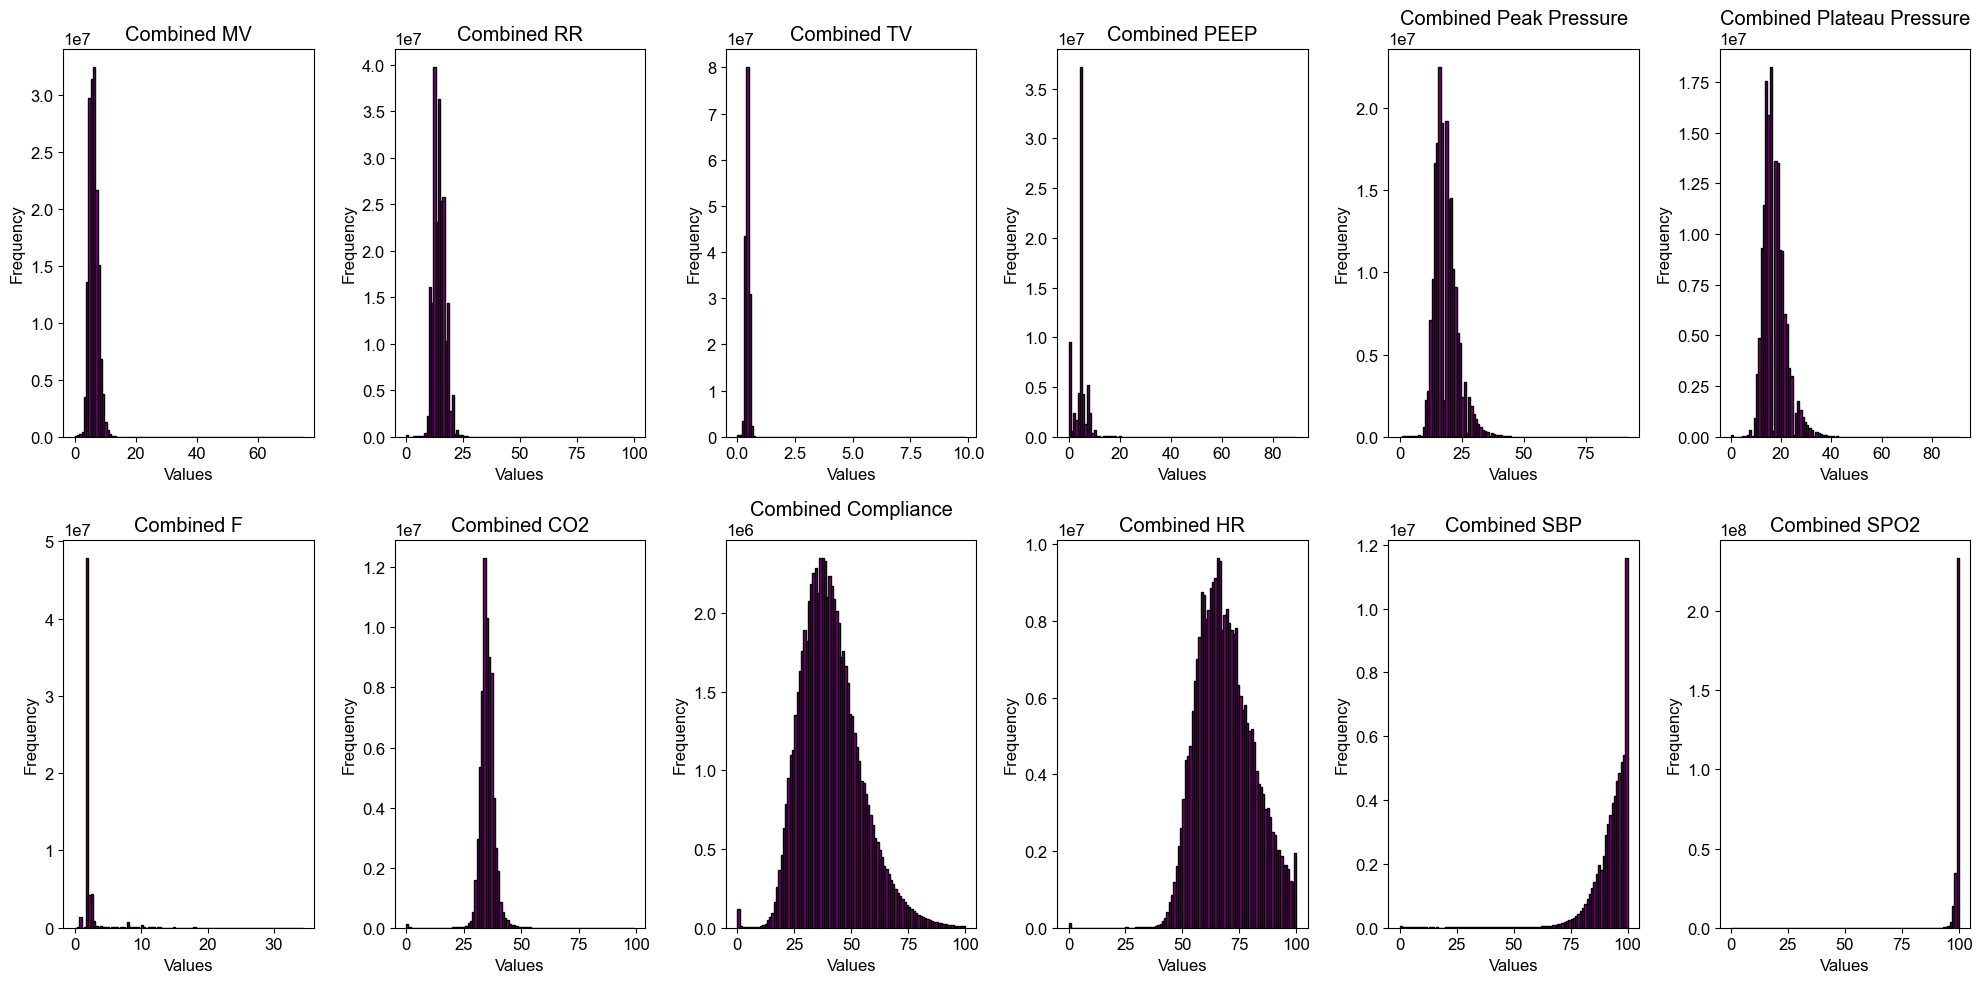

In [24]:
plot_combined_count_histograms(yearly_data)